In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import math
import seaborn as sns
from collections import OrderedDict
from matplotlib import cm
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy import stats

### Define patients without sample types

In [2]:
no_w2 = ['1769']
no_restim =['1813']
no_s6m = ['1775', '1782']
no_6m = ['1775', '1790']
no_d28 = ['1802']

patients_types = {'1769':'no well2', '1775': 'no 6m expansion and total', '1782': 'no 6m expansion', 
                  '1790': 'no 6m total', '1802': 'no d28 total'}
empty_df = pd.DataFrame(columns=['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'])

### Define functions

In [12]:
def make_factor_to_plot_column(df,col_type):
    df['cdr3'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    df = df.loc[:,['cdr3', 'freq']]
    df = df.rename(columns={'freq': 'freq_'+col_type})
    df['type_'+col_type] = col_type
    return df
def combine_types(intersect_df, list_types):
    intersect_df['type'] = intersect_df['type_'+list_types[0]].fillna('').map(str) + '&' + intersect_df['type_'+list_types[1]].fillna('').map(str)
    for x in range(2, len(list_types)):
        intersect_df['type'] = intersect_df['type'].fillna('').map(str) + '&' + intersect_df['type_'+list_types[x]].fillna('').map(str)
    intersect_df['type'].replace(r'^\&+', '', regex=True, inplace=True)
    intersect_df['type'].replace(r'\&+\Z', '', regex=True, inplace=True)     
    intersect_df['type'].replace(r'\&+', '&', regex=True, inplace=True)
    intersect_df['type'] = intersect_df['type'].replace('','None')
    #intersect_df.loc[(intersect_df['type']!='d0&d14&d28&m6')&(intersect_df['type']!='d14&d28')&(intersect_df['type']!='d14&d28&m6')&(intersect_df['type']!='d14'), 'type'] = 'other'
    
    return intersect_df
def mann_whitney_u_test(distribution_1, distribution_2):
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2,alternative = 'two-sided')
    return u_statistic, p_value

## 3A

In [6]:
path_all_venn = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/clones_from_venn/'
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'
path_all_totals = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'
path_all_s6m = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/6M_spike/nc.vdj.p'
path_all_wells = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/wells/nc.vdj.p'
all_patients_df = pd.DataFrame()
patients = [x.split('/')[-2] for x in glob.glob(path_all_venn+'*/')]
#patients = ['1769']
for patient in patients:
    patient_type = patients_types.get(patient, '')
    path_venn_cd4 = path_all_venn + patient + '/cd4.txt'
    cd4 = pd.read_csv(path_venn_cd4, delimiter='\t')
    
    path_venn_cd8 = path_all_venn + patient + '/cd8.txt'
    cd8 = pd.read_csv(path_venn_cd8, delimiter='\t')
    
    path_venn_undef = path_all_venn + patient + '/undef.txt'
    undef = pd.read_csv(path_venn_undef, delimiter='\t')
    
    path_total_d0 = path_all_totals + patient + '_total_PBMC_day_0_clonotypes.txt'
    d0 = pd.read_csv(path_total_d0, delimiter='\t')
    d0 = make_factor_to_plot_column(d0, 'd0')
    path_total_d14 = path_all_totals + patient + '_total_PBMC_day_14_clonotypes.txt'
    d14 = pd.read_csv(path_total_d14, delimiter='\t')
    d14 = make_factor_to_plot_column(d14, 'd14')
    path_total_d28 = path_all_totals + patient + '_total_PBMC_day_28_clonotypes.txt'
    try:
        d28 = pd.read_csv(path_total_d28, delimiter='\t')
        d28 = make_factor_to_plot_column(d28, 'd28')
    except:
        d28 = empty_df
        d28 = make_factor_to_plot_column(d28, 'd28')
    path_total_m6 = path_all_totals + patient + '_total_PBMC_6M_clonotypes.txt'
    try:
        m6 = pd.read_csv(path_total_m6, delimiter='\t')
        m6 = make_factor_to_plot_column(m6, 'm6')
    except:
        m6 = empty_df
        m6 = make_factor_to_plot_column(m6, 'm6')
    
    path_exp_s6m = path_all_s6m + patient +'_Spike_exp_6M_clonotypes.txt'
    try:
        s6m = pd.read_csv(path_exp_s6m, delimiter='\t')
    except:
        s6m = empty_df
    s6m = make_factor_to_plot_column(s6m, 's6m')
    
    path_exp_d14_w1 = path_all_wells + patient + '_Spike_exp_puls_well_1_clonotypes.txt'
    d14_w1 = pd.read_csv(path_exp_d14_w1, delimiter='\t')
    d14_w1 = make_factor_to_plot_column(d14_w1, 'w1')
    path_exp_d14_w2 = path_all_wells + patient + '_Spike_exp_puls_well_2_clonotypes.txt'
    try:
        d14_w2 = pd.read_csv(path_exp_d14_w2, delimiter='\t')
        d14_w2 = make_factor_to_plot_column(d14_w2, 'w2')
        d14_exp = d14_w1.merge(d14_w2, how='outer', on='cdr3').fillna(0)
        d14_exp['freq_well'] = (d14_exp['freq_w1'] + d14_exp['freq_w2'])/2.0
        d14_exp = d14_exp.loc[:, ['cdr3', 'freq_well']]
        print(d14_exp['freq_well'].sum())
    except:
        d14_exp = d14_w1.copy()
        d14_exp = d14_exp.rename(columns={'freq_w1': 'freq_well'})
    d14_exp['type_well'] = 'well'
    
    #CD4
    cd4_dynamics = cd4.merge(d0, how='left', on='cdr3').merge(d14, how='left', on='cdr3').merge(d28, how='left', on='cdr3').merge(m6, how='left', on='cdr3')
    cd4_dynamics_to_all = cd4_dynamics.copy()
    cd4_dynamics_to_all['CD'] = 'cd4'
    
    num_not_nan_cd4 = pd.DataFrame(cd4_dynamics.count(), columns=['count'])
    num_not_nan_cd4 = num_not_nan_cd4.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'count':'cd4'})
    
    cd4_dynamics = combine_types(cd4_dynamics, ['d0', 'd14', 'd28', 'm6']).fillna(0)
    
    cd4_in_exp = cd4.merge(s6m, how='left', on='cdr3').merge(d14_exp, how='left', on='cdr3')
    cd4_in_exp_to_all = cd4_in_exp.copy()
    cd4_in_exp_to_all['CD'] = 'cd4'
    
    num_not_nan_cd4_exp = pd.DataFrame(cd4_in_exp.count(), columns=['count'])
    num_not_nan_cd4_exp = num_not_nan_cd4_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'count':'cd4'})
    
    cd4_in_exp = combine_types(cd4_in_exp, ['s6m', 'well']).fillna(0)
    
    #CD8
    cd8_dynamics = cd8.merge(d0, how='left', on='cdr3').merge(d14, how='left', on='cdr3').merge(d28, how='left', on='cdr3').merge(m6, how='left', on='cdr3')
    cd8_dynamics_to_all = cd8_dynamics.copy()
    cd8_dynamics_to_all['CD'] = 'cd8'
    
    num_not_nan_cd8 = pd.DataFrame(cd8_dynamics.count(), columns=['count'])
    num_not_nan_cd8 = num_not_nan_cd8.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'count':'cd8'})
    
    cd8_dynamics = combine_types(cd8_dynamics, ['d0', 'd14', 'd28', 'm6']).fillna(0)
    
    cd8_in_exp = cd8.merge(s6m, how='left', on='cdr3').merge(d14_exp, how='left', on='cdr3')
    cd8_in_exp_to_all = cd8_in_exp.copy()
    cd8_in_exp_to_all['CD'] = 'cd8'
    
    num_not_nan_cd8_exp = pd.DataFrame(cd8_in_exp.count(), columns=['count'])
    num_not_nan_cd8_exp = num_not_nan_cd8_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'count':'cd8'})
    
    cd8_in_exp = combine_types(cd8_in_exp, ['s6m', 'well']).fillna(0)
    
    #UNDEF
    undef_dynamics = undef.merge(d0, how='left', on='cdr3').merge(d14, how='left', on='cdr3').merge(d28, how='left', on='cdr3').merge(m6, how='left', on='cdr3')
    undef_dynamics_to_all = undef_dynamics.copy()
    undef_dynamics_to_all['CD'] = 'undef'
    
    num_not_nan_undef = pd.DataFrame(undef_dynamics.count(), columns=['count'])
    num_not_nan_undef = num_not_nan_undef.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'count':'undef'})
    
    undef_dynamics = combine_types(undef_dynamics, ['d0', 'd14', 'd28', 'm6']).fillna(0)
    
    undef_in_exp = undef.merge(s6m, how='left', on='cdr3').merge(d14_exp, how='left', on='cdr3')
    undef_in_exp_to_all = undef_in_exp.copy()
    undef_in_exp_to_all['CD'] = 'undef'
    
    num_not_nan_undef_exp = pd.DataFrame(undef_in_exp.count(), columns=['count'])
    num_not_nan_undef_exp = num_not_nan_undef_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'count':'undef'})
    
    undef_in_exp = combine_types(undef_in_exp, ['s6m', 'well']).fillna(0)
    
    #Make full dynamics file
    all_dynamics = cd8_dynamics_to_all.append(cd4_dynamics_to_all).append(undef_dynamics_to_all).reset_index(drop=True)
    all_dynamics_exp = cd8_in_exp_to_all.append(cd4_in_exp_to_all).append(undef_in_exp_to_all).reset_index(drop=True)
    
    num_not_nan_all= pd.DataFrame(all_dynamics.count(), columns=['count'])
    num_not_nan_all = num_not_nan_all.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'count':'all'})
    
    num_not_nan_all_exp = pd.DataFrame(all_dynamics_exp.count(), columns=['count'])
    num_not_nan_all_exp = num_not_nan_all_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'count':'all'})
    
    #Save files with all clones
    all_dynamics_path = path_all + '/dynamics/' + patient + '/'
    os.makedirs(all_dynamics_path, exist_ok = True)
    cd4_dynamics.to_csv(all_dynamics_path + 'cd4_days.txt', sep='\t', index=False)
    cd4_in_exp.to_csv(all_dynamics_path + 'cd4_exp.txt', sep='\t', index=False)
    
    cd8_dynamics.to_csv(all_dynamics_path + 'cd8_days.txt', sep='\t', index=False)
    cd8_in_exp.to_csv(all_dynamics_path + 'cd8_exp.txt', sep='\t', index=False)
    
    undef_dynamics.to_csv(all_dynamics_path + 'undef_days.txt', sep='\t', index=False)
    undef_in_exp.to_csv(all_dynamics_path + 'undef_exp.txt', sep='\t', index=False)
    
    all_dynamics.to_csv(all_dynamics_path + 'all_days.txt', sep='\t', index=False)
    all_dynamics = combine_types(all_dynamics, ['d0', 'd14', 'd28', 'm6']).fillna(0)
    all_dynamics_exp.to_csv(all_dynamics_path + 'all_exp.txt', sep='\t', index=False)
    all_dynamics_exp = combine_types(all_dynamics_exp, ['s6m', 'well']).fillna(0)
    
    #Summarize data (number of clones of each type)
    number_cd4_exp = pd.DataFrame(cd4_in_exp['type'].value_counts()).rename(columns={'type':'cd4'})
    number_cd4 = pd.DataFrame(cd4_dynamics['type'].value_counts()).rename(columns={'type':'cd4'})
    
    number_cd8_exp = pd.DataFrame(cd8_in_exp['type'].value_counts()).rename(columns={'type':'cd8'})
    number_cd8 = pd.DataFrame(cd8_dynamics['type'].value_counts()).rename(columns={'type':'cd8'})
    
    number_undef_exp = pd.DataFrame(undef_in_exp['type'].value_counts()).rename(columns={'type':'undef'})
    number_undef = pd.DataFrame(undef_dynamics['type'].value_counts()).rename(columns={'type':'undef'})
    
    number_all_exp = pd.DataFrame(all_dynamics_exp['type'].value_counts()).rename(columns={'type':'all'})
    number_all = pd.DataFrame(all_dynamics['type'].value_counts()).rename(columns={'type':'all'})
    
    #Summarize data (sum freq of clones)
    sum_cd4_exp = pd.DataFrame(cd4_in_exp.sum(), columns=['sum'])
    sum_cd4_exp = sum_cd4_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'sum':'cd4'})
    sum_cd4 = pd.DataFrame(cd4_dynamics.sum(), columns=['sum'])
    sum_cd4 = sum_cd4.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'sum':'cd4'})
    
    sum_cd8_exp = pd.DataFrame(cd8_in_exp.sum(), columns=['sum'])
    sum_cd8_exp = sum_cd8_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'sum':'cd8'})
    sum_cd8 = pd.DataFrame(cd8_dynamics.sum(), columns=['sum'])
    sum_cd8 = sum_cd8.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'sum':'cd8'})
    
    sum_undef_exp = pd.DataFrame(undef_in_exp.sum(), columns=['sum'])
    sum_undef_exp = sum_undef_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'sum':'undef'})
    sum_undef = pd.DataFrame(undef_dynamics.sum(), columns=['sum'])
    sum_undef = sum_undef.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'sum':'undef'})
    
    sum_all_exp = pd.DataFrame(all_dynamics_exp.sum(), columns=['sum'])
    sum_all_exp = sum_all_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'sum':'all'})
    sum_all = pd.DataFrame(all_dynamics.sum(), columns=['sum'])
    sum_all = sum_all.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'sum':'all'})
    
    #Summarize data (mean size of clones)
    mean_cd4_exp = pd.DataFrame(cd4_in_exp.mean(), columns=['mean'])
    mean_cd4_exp = mean_cd4_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'mean':'cd4'})
    mean_cd4 = pd.DataFrame(cd4_dynamics.mean(), columns=['mean'])
    mean_cd4 = mean_cd4.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'mean':'cd4'})
    
    mean_cd8_exp = pd.DataFrame(cd8_in_exp.mean(), columns=['mean'])
    mean_cd8_exp = mean_cd8_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'mean':'cd8'})
    mean_cd8 = pd.DataFrame(cd8_dynamics.mean(), columns=['mean'])
    mean_cd8 = mean_cd8.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'mean':'cd8'})
    
    mean_undef_exp = pd.DataFrame(undef_in_exp.mean(), columns=['mean'])
    mean_undef_exp = mean_undef_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'mean':'undef'})
    mean_undef = pd.DataFrame(undef_dynamics.mean(), columns=['mean'])
    mean_undef = mean_undef.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'mean':'undef'})
    
    mean_all_exp = pd.DataFrame(all_dynamics_exp.mean(), columns=['mean'])
    mean_all_exp = mean_all_exp.loc[['freq_s6m', 'freq_well'], :].rename(columns={'mean':'all'})
    mean_all = pd.DataFrame(all_dynamics.mean(), columns=['mean'])
    mean_all = mean_all.loc[['freq_d0', 'freq_d14', 'freq_d28', 'freq_m6'], :].rename(columns={'mean':'all'})


    #Summarize all data into sum_df
    sum_all = sum_cd4.merge(sum_cd8, how='outer', left_index=True, right_index=True).merge(sum_undef, how='outer', left_index=True, right_index=True).merge(sum_all, how='outer', left_index=True, right_index=True)
    sum_all_exp = sum_cd4_exp.merge(sum_cd8_exp, how='outer', left_index=True, right_index=True).merge(sum_undef_exp, how='outer', left_index=True, right_index=True).merge(sum_all_exp, how='outer', left_index=True, right_index=True)
    sum_all['patient'] = patient
    sum_all_exp['patient'] = patient
    
    mean_all = mean_cd4.merge(mean_cd8, how='outer', left_index=True, right_index=True).merge(mean_undef, how='outer', left_index=True, right_index=True).merge(mean_all, how='outer', left_index=True, right_index=True)
    mean_all_exp = mean_cd4_exp.merge(mean_cd8_exp, how='outer', left_index=True, right_index=True).merge(mean_undef_exp, how='outer', left_index=True, right_index=True).merge(mean_all_exp, how='outer', left_index=True, right_index=True)
    mean_all['patient'] = patient
    mean_all_exp['patient'] = patient
    
    num_all = number_cd4.merge(number_cd8, how='outer', left_index=True, right_index=True).merge(number_undef, how='outer', left_index=True, right_index=True).merge(number_all, how='outer', left_index=True, right_index=True)
    num_all_exp = number_cd4_exp.merge(number_cd8_exp, how='outer', left_index=True, right_index=True).merge(number_undef_exp, how='outer', left_index=True, right_index=True).merge(number_all_exp, how='outer', left_index=True, right_index=True)
    num_all['patient'] = patient
    num_all_exp['patient'] = patient
    
    num_not_nan_all_types = num_not_nan_cd4.merge(num_not_nan_cd8, how='outer', left_index=True, right_index=True).merge(num_not_nan_undef, how='outer', left_index=True, right_index=True).merge(num_not_nan_all, how='outer', left_index=True, right_index=True)
    num_not_nan_all_exp_types = num_not_nan_cd4_exp.merge(num_not_nan_cd8_exp, how='outer', left_index=True, right_index=True).merge(num_not_nan_undef_exp, how='outer', left_index=True, right_index=True).merge(num_not_nan_all_exp, how='outer', left_index=True, right_index=True)
    num_not_nan_all_types['patient'] = patient
    num_not_nan_all_exp_types['patient'] = patient
    
    
    #Melt df for plot
    sum_all_exp['day'] = sum_all_exp.index
    melted_sum_all_exp = pd.melt(sum_all_exp, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='sum_freq', var_name='CD')
    sum_all['day'] = sum_all.index
    melted_sum_all = pd.melt(sum_all, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='sum_freq', var_name='CD')
    
    
    mean_all_exp['day'] = mean_all_exp.index
    melted_mean_all_exp = pd.melt(mean_all_exp, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='mean_freq', var_name='CD')
    mean_all['day'] = mean_all.index
    melted_mean_all = pd.melt(mean_all, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='mean_freq', var_name='CD')
    
    
    num_all_exp['day'] = num_all_exp.index
    melted_num_all_exp = pd.melt(num_all_exp, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='num_clones', var_name='CD')
    
    num_all['day'] = num_all.index
    melted_num_all = pd.melt(num_all, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='num_clones', var_name='CD')
    
    
    num_not_nan_all_exp_types['day'] = num_not_nan_all_exp_types.index
    melted_num_not_nan_all_exp_types = pd.melt(num_not_nan_all_exp_types, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='num_clones', var_name='CD')
    
    num_not_nan_all_types['day'] = num_not_nan_all_types.index
    melted_num_not_nan_all_types = pd.melt(num_not_nan_all_types, id_vars=['day', 'patient'], value_vars=['cd4', 'cd8', 'undef', 'all'], 
                                 value_name='num_clones', var_name='CD')
    
    all_summary_patients = melted_sum_all.merge(melted_mean_all, how='outer', on=['day', 'patient', 'CD']).merge(melted_num_not_nan_all_types, how='outer', on=['day', 'patient', 'CD'])
    all_summary_patients_exp = melted_sum_all_exp.merge(melted_mean_all_exp, how='outer', on=['day', 'patient', 'CD']).merge(melted_num_not_nan_all_exp_types, how='outer', on=['day', 'patient', 'CD'])
    all_summary_patients['patient_type'] = patient_type
    all_summary_patients_exp['patient_type'] = patient_type
    all_patients_df = all_patients_df.append(all_summary_patients).append(all_summary_patients_exp).reset_index(drop=True)
    
all_patients_df_path = path_all + 'all_patients_dynamics_summary.txt'
all_patients_df.to_csv(all_patients_df_path, sep='\t', index=False)



0.999999999999989


/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:164: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: FutureWarning: Droppin

0.999999999999992


/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


0.9999999999999938
0.9999999999999925
0.9999999999999972
0.9999999999999917
0.9999999999999907
0.9999999999999882
0.9999999999999913
0.999999999999996
0.9999999999999892
0.9999999999999959
0.9999999999999885
0.9999999999999918
0.9999999999999936
0.9999999999999885


In [7]:
#Drop rows from summary withount values (with pseudo zero)
#{'1769':'no well2', '1775': 'no 6m expansion and total', '1782': 'no 6m expansion', 
#                  '1790': 'no 6m total', '1802': 'no d28 total'}
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

all_patients_df_dropped = all_patients_df.drop(all_patients_df[(all_patients_df['patient_type']=='no 6m expansion and total')&((all_patients_df['day']=='freq_s6m')|(all_patients_df['day']=='freq_m6'))].index)
all_patients_df_dropped = all_patients_df_dropped.drop(all_patients_df_dropped[(all_patients_df_dropped['patient_type']=='no 6m expansion')&(all_patients_df_dropped['day']=='freq_s6m')].index)
all_patients_df_dropped = all_patients_df_dropped.drop(all_patients_df_dropped[(all_patients_df_dropped['patient_type']=='no 6m total')&(all_patients_df_dropped['day']=='freq_m6')].index)
all_patients_df_dropped = all_patients_df_dropped.drop(all_patients_df_dropped[(all_patients_df_dropped['patient_type']=='no d28 total')&(all_patients_df_dropped['day']=='freq_d28')].index)

print(len(all_patients_df_dropped), len(all_patients_df))
all_patients_df_dropped_path = path_all + 'all_patients_dynamics_summary_not_wrong_zero.txt'
all_patients_df_dropped.to_csv(all_patients_df_dropped_path, sep='\t', index=False)

388 408


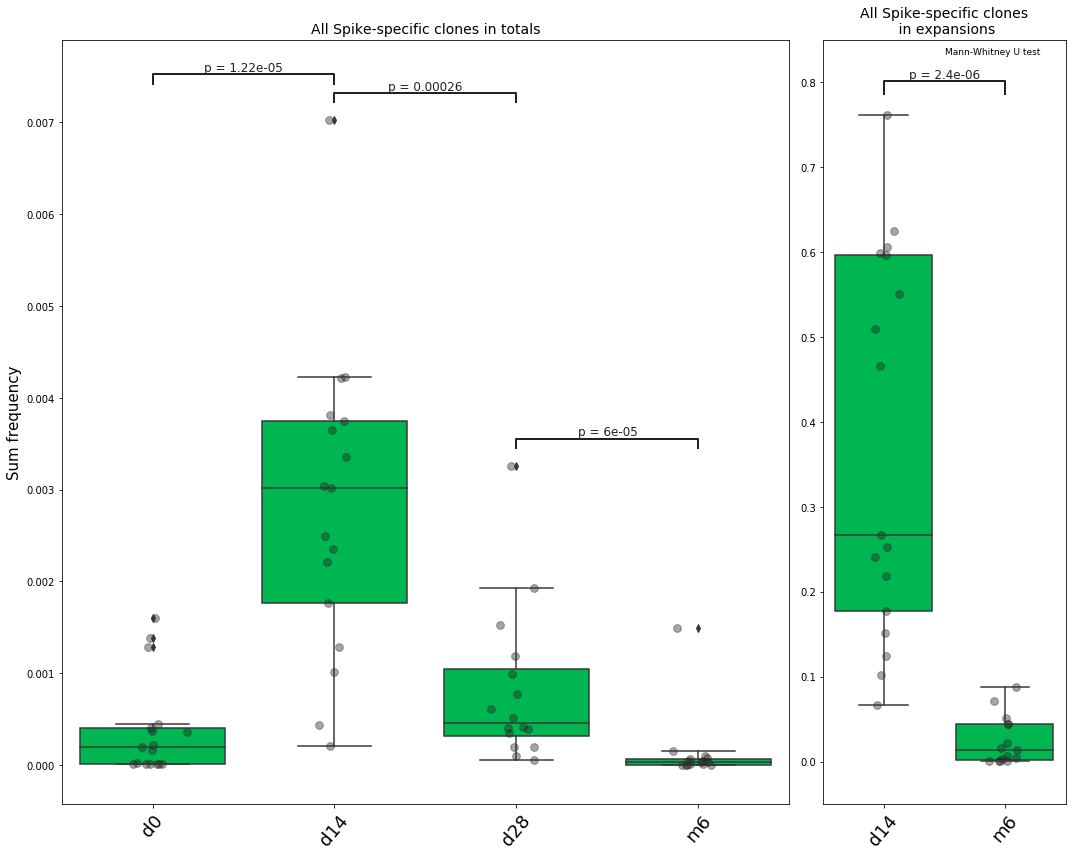

<Figure size 1080x864 with 0 Axes>

In [16]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['CD']=='all']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']
plt.figure()
plt.rcParams["figure.figsize"] = (15,12)

ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1, ax=a0)
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency',fontsize='15')
ax.set_xlabel('')
ax.set_title('All Spike-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(2, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(3, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.0004, 0.0001, 'k'
a0.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['sum_freq']))[1],7)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['sum_freq'].max() + 0.0002, 0.0001, 'k'
a0.plot([2, 2, 3, 3], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(2.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.0002, 0.0001, 'k'
a0.plot([2, 2, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(1.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']=='freq_s6m')|(all_patients_df_dropped['day']=='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['CD']=='all']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_s6m':'m6', 'freq_well':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']

ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([-0.05, 0.85])
ax.set_title('All Spike-specific clones\n in expansions',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.025, 0.015, 'k'
a1.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a1.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq']))[1],7)),
         ha='center', va='bottom', color='#222222', fontsize=12)


a1.text(0.9, 0.83, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)

path_to_png = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3A/3A(all_clones_sum_freq).png'
plt.tight_layout()
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)
plt.show()


#Count statistics to table
statistics = pd.DataFrame()

for x in list(all_patients_df_dropped['day'].unique()):
    for y in list(all_patients_df_dropped['day'].unique()):
        if x!=y:
            pval = mann_whitney_u_test(list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='all')&(all_patients_df_dropped['day']==x)]['sum_freq']), 
                    list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='all')&(all_patients_df_dropped['day']==y)]['sum_freq']))[1]
            new_row = {'X': x, 'Y': y, 'Pval': pval}
            statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3A/pval(all_clones_sum_freq).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)



## 3B

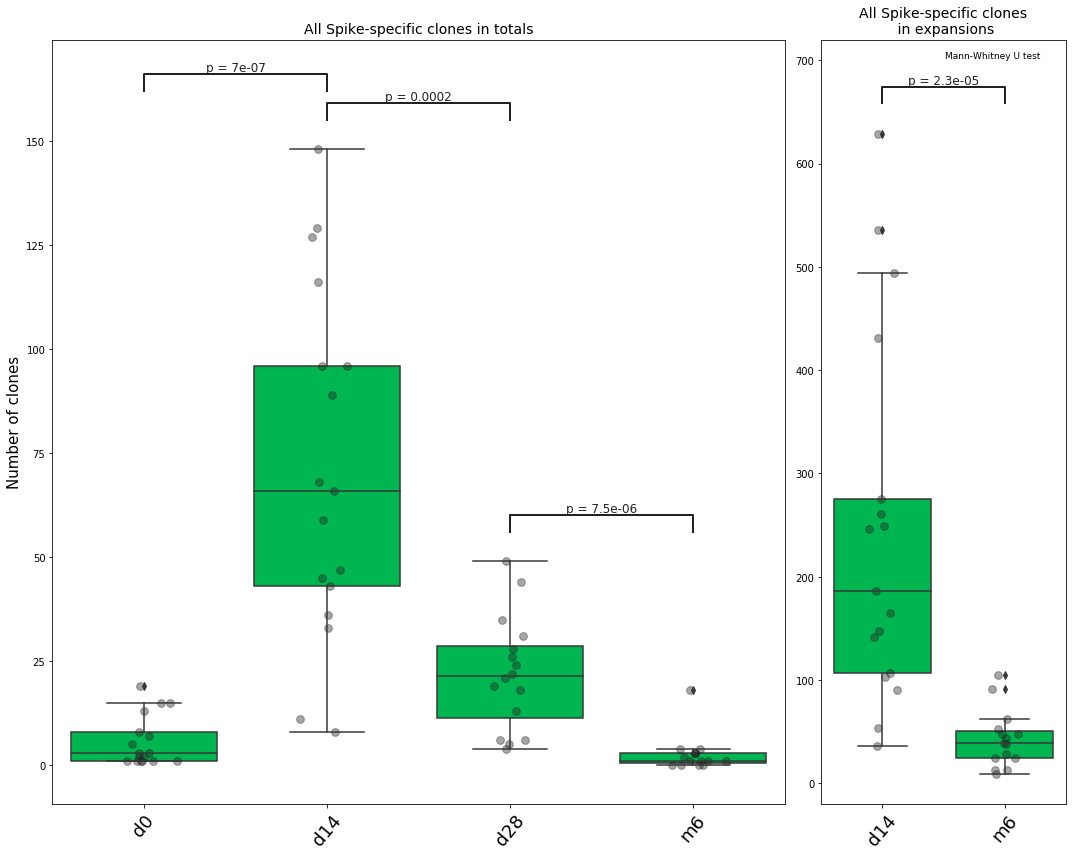

<Figure size 1080x864 with 0 Axes>

In [17]:
#Plot figures num clomnes
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['CD']=='all']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']
plt.figure()
plt.rcParams["figure.figsize"] = (15,12)

ax = sns.boxplot(x="day", y="num_clones", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1, ax=a0)
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Number of clones',fontsize='15')
ax.set_xlabel('')
ax.set_title('All Spike-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['num_clones'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num_clones'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(2, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num_clones'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(3, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num_clones'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num_clones'].max() + 14, 4, 'k'
a0.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['num_clones']))[1],7)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['num_clones'].max() + 7, 4, 'k'
a0.plot([2, 2, 3, 3], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(2.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num_clones']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num_clones']))[1],7)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num_clones'].max() + 7, 4, 'k'
a0.plot([2, 2, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(1.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num_clones']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num_clones']))[1],4)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']=='freq_s6m')|(all_patients_df_dropped['day']=='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['CD']=='all']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_s6m':'m6', 'freq_well':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']

ax = sns.boxplot(x="day", y="num_clones", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([-20, 720])
ax.set_title('All Spike-specific clones\n in expansions',fontsize=14)

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num_clones'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num_clones'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num_clones'].max() + 30, 15, 'k'
a1.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a1.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num_clones']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num_clones']))[1],6)),
         ha='center', va='bottom', color='#222222', fontsize=12)


a1.text(0.9, 700, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)

path_to_png = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3B/3B(all_clones_num).png'
plt.tight_layout()
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)
plt.show()

#Count statistics to table
statistics = pd.DataFrame()

for x in list(all_patients_df_dropped['day'].unique()):
    for y in list(all_patients_df_dropped['day'].unique()):
        if x!=y:
            pval = mann_whitney_u_test(list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='all')&(all_patients_df_dropped['day']==x)]['num_clones']), 
                    list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='all')&(all_patients_df_dropped['day']==y)]['num_clones']))[1]
            new_row = {'X': x, 'Y': y, 'Pval': pval}
            statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3B/pval(all_clones_num).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)

## 3C

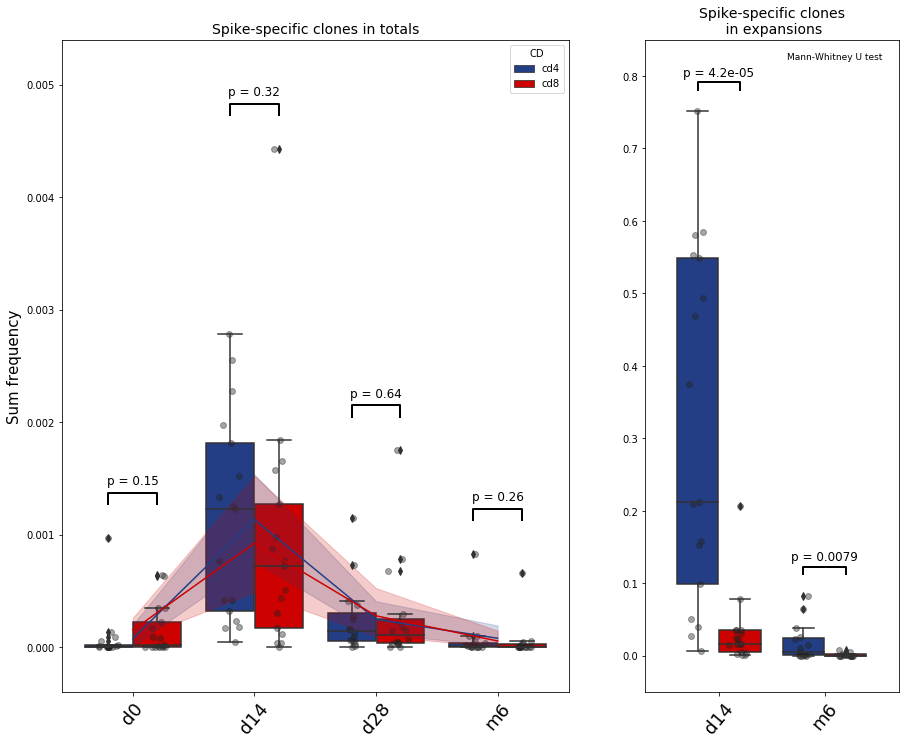

<Figure size 1080x864 with 0 Axes>

In [22]:
#Plot figures sum freq all CD not all
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']!='all')&(all_patients_df_dropped_to_plot['CD']!='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#233e84', '#cc0100']

plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, saturation=1, ax=a0)

plt.sca(a0)
#CD8
x = np.random.normal(0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(2.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(3.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

#CD4
x = np.random.normal(-0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(0.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(2.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)


ax.set_ylim([-0.0004, 0.0054])

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')]['sum_freq'].max() + 0.0003, 0.0001, 'k'
a0.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(0, y+h+0.00005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],3)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.0003, 0.0001, 'k'
a0.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(1, y+h+0.00005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],2)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['sum_freq'].max() + 0.0003, 0.0001, 'k'
a0.plot([1.8, 1.8, 2.2, 2.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(2, y+h+0.00005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],2)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')]['sum_freq'].max() + 0.0003, 0.0001, 'k'
a0.plot([2.8, 2.8, 3.2, 3.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(3, y+h+0.00005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],2)),
         ha='center', va='bottom', color=col, fontsize=12)

ax = sns.lineplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, ax=a0, legend=False)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency',fontsize='15')
ax.set_xlabel('')

ax.set_title('Spike-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']=='freq_s6m')|(all_patients_df_dropped['day']=='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']!='all')&(all_patients_df_dropped_to_plot['CD']!='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_s6m':'m6', 'freq_well':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([-0.05, 0.85])
ax.set_title('Spike-specific clones\n in expansions',fontsize=14)# (0.0000005=0)',fontsize='small')# )

#CD8
x = np.random.normal(0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq'], c='#222222', alpha=0.4, s=35)

#CD4
x = np.random.normal(-0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(0.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq'], c='#222222', alpha=0.4, s=35)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.03, 0.01, 'k'
a1.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=2, c=col)
a1.text(0, y+h+0.005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],6)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')]['sum_freq'].max() + 0.03, 0.01, 'k'
a1.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=2, c=col)
a1.text(1, y+h+0.005, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['sum_freq']))[1],4)),
         ha='center', va='bottom', color=col, fontsize=12)


a1.text(1.1, 0.82, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)

a1.get_legend().remove()
path_to_png = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3C/3C(cd4_cd8_clones_sum_freq_with_trend).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)


#Count statistics to table
statistics = pd.DataFrame()

for x in list(all_patients_df_dropped['day'].unique()):
    pval = mann_whitney_u_test(list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='cd4')&(all_patients_df_dropped['day']==x)]['sum_freq']), 
            list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='cd8')&(all_patients_df_dropped['day']==x)]['sum_freq']))[1]
    new_row = {'X': x, 'Pval': pval}
    statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3C/pval(cd4_vs_cd8_clones_sum_freq).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)

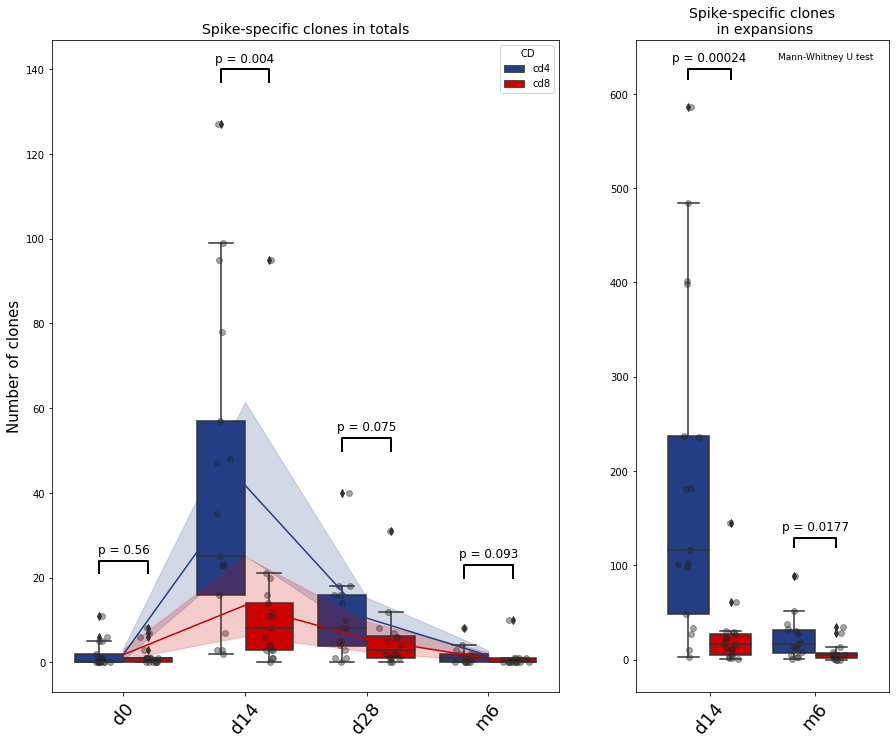

<Figure size 1080x864 with 0 Axes>

In [23]:
#Plot figures num clones all CD not all
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']!='all')&(all_patients_df_dropped_to_plot['CD']!='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#233e84', '#cc0100']


plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.boxplot(x="day", y="num_clones", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, saturation=1, ax=a0)
plt.sca(a0)

#CD8
x = np.random.normal(0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(2.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(3.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

#CD4
x = np.random.normal(-0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(0.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(2.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a0.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)



y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')]['num_clones'].max() + 10, 3, 'k'
a0.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(0, y+h+1, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d0')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1],2)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num_clones'].max() + 10, 3, 'k'
a0.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(1, y+h+1, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1], 3)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['num_clones'].max() + 10, 3, 'k'
a0.plot([1.8, 1.8, 2.2, 2.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(2, y+h+1, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1], 3)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')]['num_clones'].max() + 10, 3, 'k'
a0.plot([2.8, 2.8, 3.2, 3.2], [y, y+h, y+h, y], lw=2, c=col)
a0.text(3, y+h+1, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1], 3)),
         ha='center', va='bottom', color=col, fontsize=12)
ax = sns.lineplot(x="day", y="num_clones", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, ax=a0, legend=False)

plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Number of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('Spike-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']=='freq_s6m')|(all_patients_df_dropped['day']=='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']!='all')&(all_patients_df_dropped_to_plot['CD']!='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_s6m':'m6', 'freq_well':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

ax = sns.boxplot(x="day", y="num_clones", data=all_patients_df_dropped_to_plot, hue='CD', palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')

ax.set_title('Spike-specific clones\n in expansions',fontsize=14)

#CD8
x = np.random.normal(0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(1.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones'], c='#222222', alpha=0.4, s=35)

#CD4
x = np.random.normal(-0.2, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)

x = np.random.normal(0.8, 0.04, size=len(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]))
a1.scatter(x, all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones'], c='#222222', alpha=0.4, s=35)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num_clones'].max() + 30, 10, 'k'
a1.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=2, c=col)
a1.text(0, y+h+5, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1],5)),
         ha='center', va='bottom', color=col, fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')]['num_clones'].max() + 30, 10, 'k'
a1.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=2, c=col)
a1.text(1, y+h+5, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd4')]['num_clones']), 
                    list(all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='m6')&(all_patients_df_dropped_to_plot['CD']=='cd8')]['num_clones']))[1],4)),
         ha='center', va='bottom', color=col, fontsize=12)

a1.text(1.1, 635, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)



a1.get_legend().remove()
path_to_png = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3C/3C(cd4_cd8_clones_num_clones_with_trend).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)


#Count statistics to table
statistics = pd.DataFrame()

for x in list(all_patients_df_dropped['day'].unique()):
    pval = mann_whitney_u_test(list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='cd4')&(all_patients_df_dropped['day']==x)]['num_clones']), 
            list(all_patients_df_dropped[(all_patients_df_dropped['CD']=='cd8')&(all_patients_df_dropped['day']==x)]['num_clones']))[1]
    new_row = {'X': x, 'Pval': pval}
    statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/3C/pval(cd4_vs_cd8_clones_num_clones).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)

## 3D

In [24]:
path_all_venn = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/clones_from_venn/'
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

path_all_totals = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'
path_all_s6m = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/6M_spike/nc.vdj.p'
path_all_wells = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/wells/nc.vdj.p'
all_patients_dynamics = pd.DataFrame()
patients = [x.split('/')[-2] for x in glob.glob(path_all_venn+'*/')]
for patient in patients:
    patient_type = patients_types.get(patient, '')
    if (patient != '1775')&(patient != '1782'):
        path_venn_cd4 = path_all_venn + patient + '/cd4.txt'
        cd4 = pd.read_csv(path_venn_cd4, delimiter='\t')

        path_venn_cd8 = path_all_venn + patient + '/cd8.txt'
        cd8 = pd.read_csv(path_venn_cd8, delimiter='\t')

        path_venn_undef = path_all_venn + patient + '/undef.txt'
        undef = pd.read_csv(path_venn_undef, delimiter='\t')

        path_exp_s6m = path_all_s6m + patient +'_Spike_exp_6M_clonotypes.txt'
        try:
            s6m = pd.read_csv(path_exp_s6m, delimiter='\t')
        except:
            s6m = empty_df
        s6m = make_factor_to_plot_column(s6m, 's6m')

        path_total_d14 = path_all_totals + patient + '_total_PBMC_day_14_clonotypes.txt'
        d14 = pd.read_csv(path_total_d14, delimiter='\t')
        d14 = make_factor_to_plot_column(d14, 'd14')

        #CD4
        cd4_dynamics = cd4.merge(d14, how='left', on='cdr3').merge(s6m, how='left', on='cdr3')

        cd4_dynamics_to_all = cd4_dynamics.copy()
        cd4_dynamics_to_all['CD'] = 'cd4'

        num_not_nan_cd4 = pd.DataFrame(cd4_dynamics.count(), columns=['count'])
        num_not_nan_cd4 = num_not_nan_cd4.loc[['freq_d14', 'freq_s6m'], :].rename(columns={'count':'cd4'})

        cd4_dynamics = combine_types(cd4_dynamics, ['d14', 's6m']).fillna(0)

        #CD8
        cd8_dynamics = cd8.merge(d14, how='left', on='cdr3').merge(s6m, how='left', on='cdr3')
        cd8_dynamics_to_all = cd8_dynamics.copy()
        cd8_dynamics_to_all['CD'] = 'cd8'

        num_not_nan_cd8 = pd.DataFrame(cd8_dynamics.count(), columns=['count'])
        num_not_nan_cd8 = num_not_nan_cd8.loc[['freq_d14', 'freq_s6m'], :].rename(columns={'count':'cd8'})

        cd8_dynamics = combine_types(cd8_dynamics, ['d14', 's6m']).fillna(0)

        #UNDEF
        undef_dynamics = undef.merge(d14, how='left', on='cdr3').merge(s6m, how='left', on='cdr3')
        undef_dynamics_to_all = undef_dynamics.copy()
        undef_dynamics_to_all['CD'] = 'undef'

        num_not_nan_undef = pd.DataFrame(undef_dynamics.count(), columns=['count'])
        num_not_nan_undef = num_not_nan_undef.loc[['freq_d14', 'freq_s6m'], :].rename(columns={'count':'undef'})

        undef_dynamics = combine_types(undef_dynamics, ['d14', 's6m']).fillna(0)

        #Make full dynamics file
        all_dynamics = cd8_dynamics_to_all.append(cd4_dynamics_to_all).append(undef_dynamics_to_all).reset_index(drop=True)

        num_not_nan_all= pd.DataFrame(all_dynamics.count(), columns=['count'])
        num_not_nan_all = num_not_nan_all.loc[['freq_d14', 'freq_s6m'], :].rename(columns={'count':'all'})

        #Save files with all clones
        all_dynamics_path = path_all + '/dynamics/' + patient +'/'
        os.makedirs(all_dynamics_path, exist_ok = True)
        
        cd4_dynamics.to_csv(all_dynamics_path + 'cd4_d14_s6m.txt', sep='\t', index=False)

        cd8_dynamics.to_csv(all_dynamics_path + 'cd8_d14_s6m.txt', sep='\t', index=False)

        undef_dynamics.to_csv(all_dynamics_path + 'undef_d14_s6m.txt', sep='\t', index=False)

        all_dynamics.to_csv(all_dynamics_path + 'all_d14_s6m.txt', sep='\t', index=False)

        all_dynamics = combine_types(all_dynamics, ['d14', 's6m']).fillna(0)
        all_dynamics['patient'] = patient
        all_patients_dynamics = all_patients_dynamics.append(all_dynamics).reset_index(drop=True)
        print(patient)
all_patients_dynamics_path = path_all + 'all_patients_dynamics_d14_vs_s6m.txt'
all_patients_dynamics.to_csv(all_patients_dynamics_path, sep='\t', index=False)
all_patients_dynamics



1792
1790
1800
1810
1752
1813
1802
1771
1769
1787
1765
1780
1753
1757
1776


,cdr3,type,freq_d14,type_d14,freq_s6m,type_s6m,CD,patient
0,TGCAGTGCTAGGCAGTGGGGGGACAACTATGGCTACACCTTC|TRB...,d14&s6m,0.000075,d14,0.000008,s6m,cd8,1792
1,TGTGCCAGCAGCCAAGAACGGGCTAGCGGGCGCTACGAGCAGTACT...,d14&s6m,0.000061,d14,0.000399,s6m,cd8,1792
2,TGTGCCAGCAGCTTAGACTCCGGATCTCGGAGGTGGGGGGCCAACG...,d14&s6m,0.000163,d14,0.004669,s6m,cd8,1792
3,TGCAGCGTTGAAGATCTAGGCCGAAGGGTTACTGAAGCTTTCTTT|...,s6m,0.000000,0,0.000878,s6m,cd4,1792
4,TGCAGCGTTTTCGGATACTCCTACGAGCAGTACTTC|TRBV29-1|...,None,0.000000,0,0.000000,0,cd4,1792
...,...,...,...,...,...,...,...,...
3568,TGTGCCAGCAGTGTCAGGACAGGGGCTCTCGATGGCTACACCTTC|...,None,0.000000,0,0.000000,0,undef,1776
3569,TGTGCCAGCAGTTACAACGGGAGAGGAACAGATACGCAGTATTTT|...,d14,0.000009,d14,0.000000,0,undef,1776
3570,TGTGCCAGCCAACCCTCCATCACCTTC|TRBV7-9|TRBJ1-2,d14,0.000017,d14,0.000000,0,undef,1776
3571,TGTGCCAGGGGACCTAGCCACGAGCAGTACTTC|TRBV6-1|TRBJ2-7,d14&s6m,0.000004,d14,0.000041,s6m,undef,1776


In [ ]:
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']!=0)&(all_patients_dynamics['CD']=='undef')]
x = 0.1
y = 0

#Undef
dict_quartiles = {}
while (x < 1)|(y<1):
    
    if y == 0:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))])
        
        dict_quartiles[x] = is_in/all_in
    elif y > 0.95:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))])
        dict_quartiles[0.99] = is_in/all_in
    else:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))])
        dict_quartiles[x] = is_in/all_in
    print(all_in)
    y = round(y + 0.1,1)
    x = round(x + 0.1,1)
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']==0)&(all_patients_dynamics['CD']=='undef')]
is_in = len(to_hist[(to_hist['freq_d14']==0)&(to_hist['type_s6m']!=0)])
all_in = len(to_hist[(to_hist['freq_d14']==0)])
dict_quartiles[0] = is_in/all_in
dict_quartiles_undef = dict_quartiles

#CD4
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']!=0)&(all_patients_dynamics['CD']=='cd4')]
x = 0.1
y = 0
dict_quartiles = {}
while (x < 1)|(y<1):
    
    if y == 0:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))])
        
        dict_quartiles[x] = is_in/all_in
    elif y > 0.95:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))])
        dict_quartiles[0.99] = is_in/all_in
    else:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))])
        dict_quartiles[x] = is_in/all_in
    print(all_in)
    y = round(y + 0.1,1)
    x = round(x + 0.1,1)
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']==0)&(all_patients_dynamics['CD']=='cd4')]
is_in = len(to_hist[(to_hist['freq_d14']==0)&(to_hist['type_s6m']!=0)])
all_in = len(to_hist[(to_hist['freq_d14']==0)])
dict_quartiles[0] = is_in/all_in
dict_quartiles_cd4 = dict_quartiles

#CD8
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']!=0)&(all_patients_dynamics['CD']=='cd8')]
x = 0.1
y = 0
dict_quartiles = {}
while (x < 1)|(y<1):
    
    if y == 0:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))])
        
        dict_quartiles[x] = is_in/all_in
    elif y > 0.95:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], 0.9999))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], 0.95))])
        dict_quartiles[0.99] = is_in/all_in
    else:
        is_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))&(to_hist['type_s6m']!=0)])
        all_in = len(to_hist[(to_hist['freq_d14']<=np.quantile(to_hist['freq_d14'], x))&(to_hist['freq_d14']>np.quantile(to_hist['freq_d14'], y))])
        dict_quartiles[x] = is_in/all_in
    print(all_in)
    y = round(y + 0.1,1)
    x = round(x + 0.1,1)
to_hist = all_patients_dynamics[(all_patients_dynamics['freq_d14']==0)&(all_patients_dynamics['CD']=='cd8')]
is_in = len(to_hist[(to_hist['freq_d14']==0)&(to_hist['type_s6m']!=0)])
all_in = len(to_hist[(to_hist['freq_d14']==0)])
dict_quartiles[0] = is_in/all_in
dict_quartiles_cd8 = dict_quartiles

plt.figure()
plt.rcParams["figure.figsize"] = (12,9)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([x + 0.005 for x in list(dict_quartiles_cd4.keys())],list(dict_quartiles_cd4.values()),width = 0.08, color='#233e84', alpha=0.3,label='CD4 S-specific clones')
ax.bar([x-0.005 for x in list(dict_quartiles_cd8.keys())],list(dict_quartiles_cd8.values()),width = 0.08, color='#cc0100', alpha=0.3,label='CD8 S-specific clones')
ax.bar(list(dict_quartiles_undef.keys()),list(dict_quartiles_undef.values()),width = 0.08, color='#8c8c8c', alpha=0.3,label='Undef S-specific clones')

ax.set_ylabel('Share of clones found in expansion 6m')
ax.set_xlabel('Quantile')
ax.set_ylim([-0.05, 1.15])

plt.legend()
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'
path_to_png = path_all + '3D/3D(cd4_cd8_undef).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)



## S3A

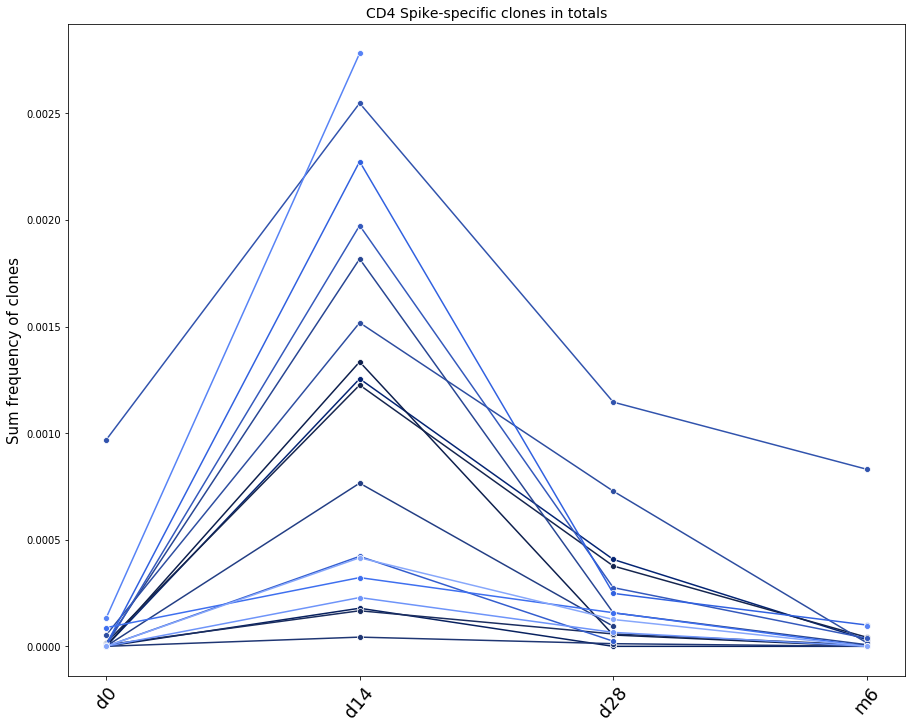

<Figure size 1080x864 with 0 Axes>

In [31]:
#Plot figures sum freq CD4
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='cd4')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#042473', '#08215F', '#0D1F4D', '#15254E', '#1A2D5F', '#1F3673', '#233E84', '#284693', '#2D4DA0', '#3153AD',
 '#3459BC', '#335DCE', '#3161E0', '#3E6FEF', '#5783F6', '#6E94F9', '#87A7FB']

plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('CD4 Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'/S3AC/S3A(cd4_sum_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3AC/S3A(cd4_sum_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)

## S3B

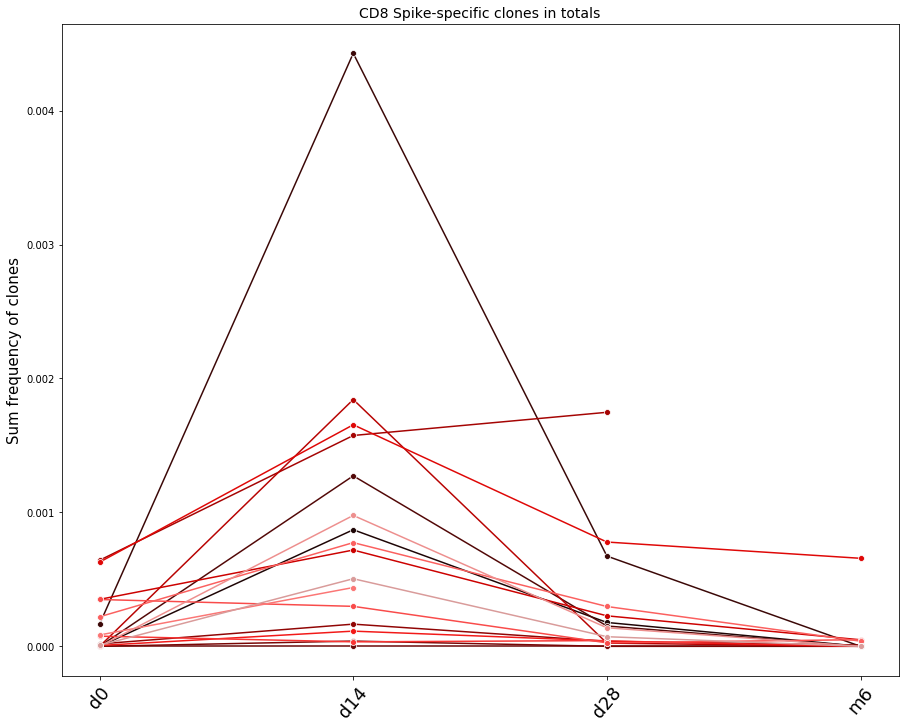

<Figure size 1080x864 with 0 Axes>

In [32]:
#Plot figures sum freq CD8
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='cd8')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#1E0505', '#3B0807', '#520807', '#660706', '#790605', '#900504', '#A50403', '#B80302', '#cc0100', '#DF0807',
'#F21918', '#F83534', '#F94B4A', '#FB605F', '#FB7675', '#ED8F8E', '#D99B9A']

plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('CD8 Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'/S3AC/S3B(cd8_sum_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3AC/S3B(cd8_sum_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)

## S3C

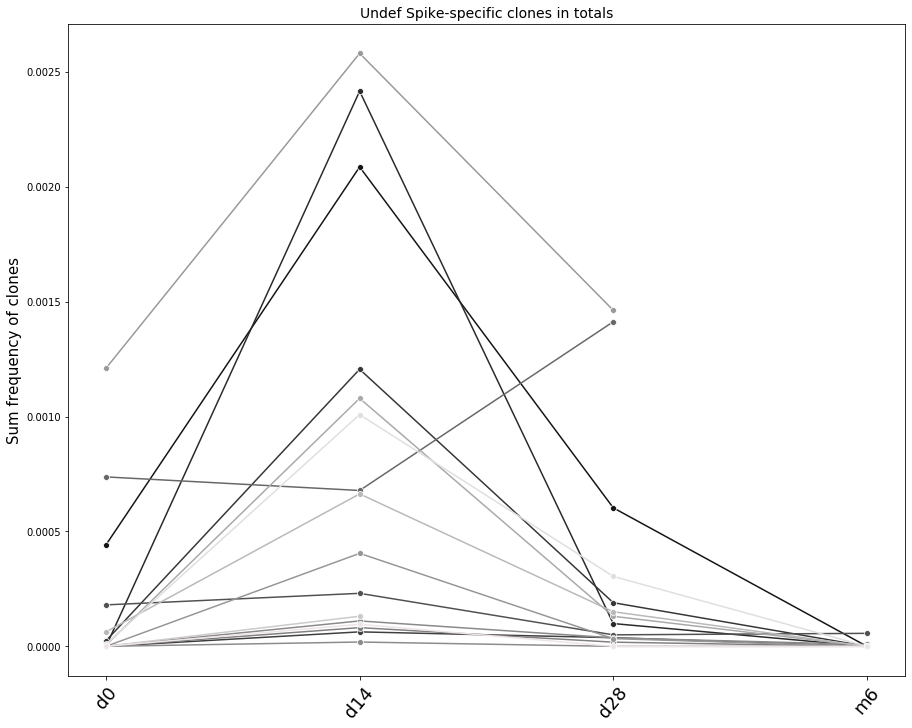

<Figure size 1080x864 with 0 Axes>

In [33]:
#Plot figures sum freq Undef
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['patient']!='1769']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#141414', '#2A2A2A', '#363636', '#3E3E3E', '#525151', '#676767', '#808080', '#898989', '#8C8C8C', '#969696',  
'#999999', '#A9A9A9',  '#B9B9B9', '#CBCBCB', '#DFDFDF', '#EDE5E5']


plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('Undef Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'/S3AC/S3C(undef_sum_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3AC/S3C(undef_sum_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)

## S3D

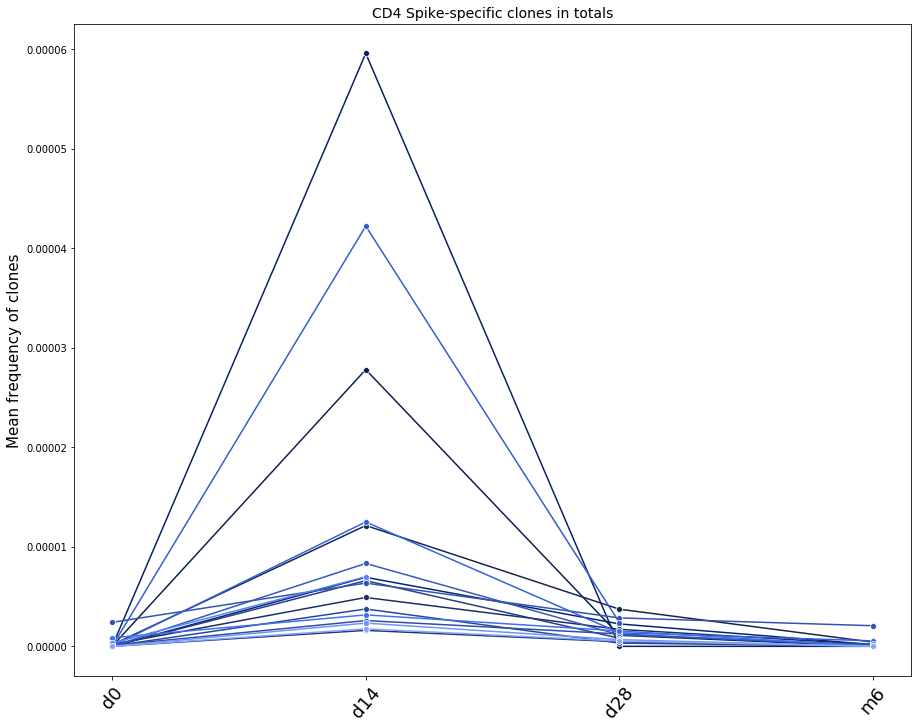

<Figure size 1080x864 with 0 Axes>

In [36]:
#Plot figures mean freq CD4
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='cd4')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#042473', '#08215F', '#0D1F4D', '#15254E', '#1A2D5F', '#1F3673', '#233E84', '#284693', '#2D4DA0', '#3153AD',
 '#3459BC', '#335DCE', '#3161E0', '#3E6FEF', '#5783F6', '#6E94F9', '#87A7FB']

plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="mean_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Mean frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('CD4 Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'S3DF/S3D(cd4_mean_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3DF/S3D(cd4_mean_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)

## S3E

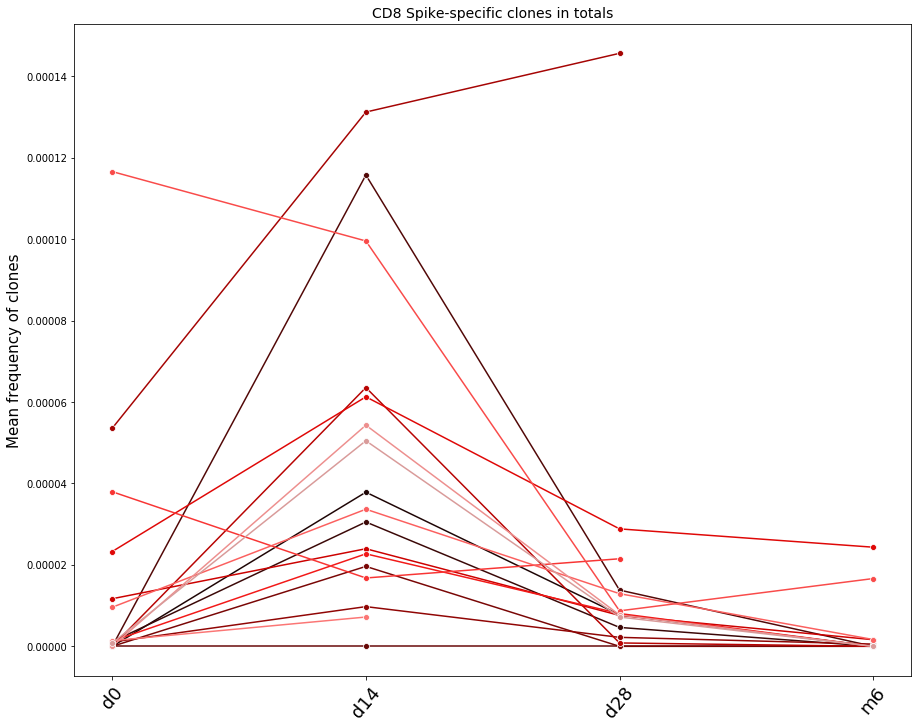

<Figure size 1080x864 with 0 Axes>

In [37]:
#Plot figures mean freq CD8
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='cd8')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#1E0505', '#3B0807', '#520807', '#660706', '#790605', '#900504', '#A50403', '#B80302', '#cc0100', '#DF0807',
'#F21918', '#F83534', '#F94B4A', '#FB605F', '#FB7675', '#ED8F8E', '#D99B9A']

plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="mean_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Mean frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('CD8 Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'/S3DF/S3E(cd8_mean_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3DF/S3E(cd8_mean_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)

## S3F

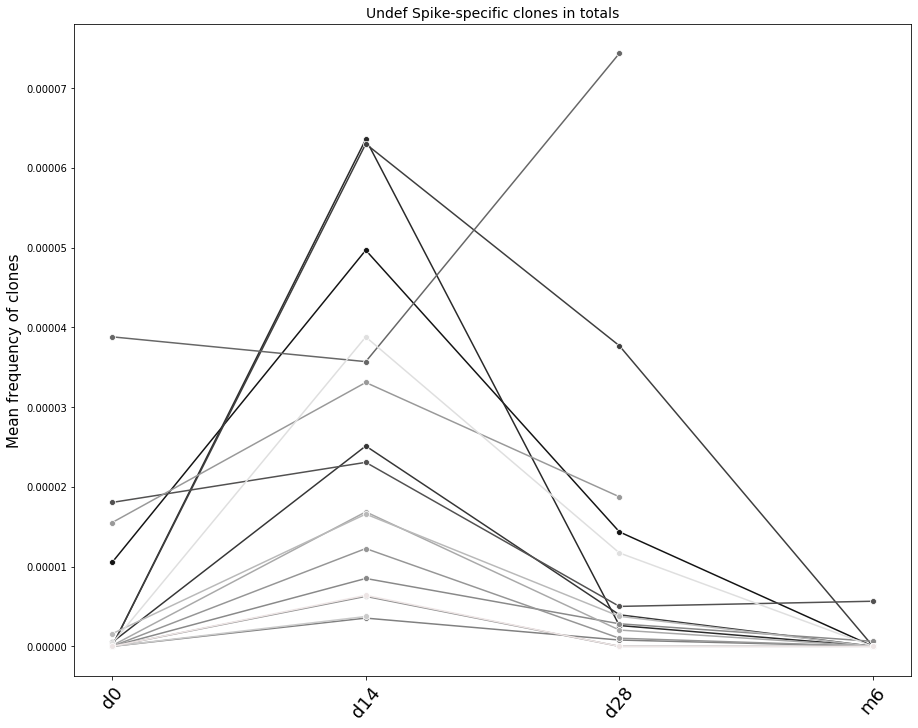

<Figure size 1080x864 with 0 Axes>

In [38]:
#Plot figures mean freq Undef
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig3/'

f, (a0) = plt.subplots(1, 1)
all_patients_df_dropped_to_plot = all_patients_df_dropped[(all_patients_df_dropped['day']!='freq_s6m')&(all_patients_df_dropped['day']!='freq_well')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['patient']!='1769']
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['CD']=='undef')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'freq_d0':'d0', 'freq_d14':'d14', 'freq_d28':'d28', 'freq_m6':'m6'})
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values(['day', 'CD'])

pallet_wells = ['#141414', '#2A2A2A', '#363636', '#3E3E3E', '#525151', '#676767', '#808080', '#898989', '#8C8C8C', '#969696',  
'#999999', '#A9A9A9',  '#B9B9B9', '#CBCBCB', '#DFDFDF', '#EDE5E5']


plt.figure()
plt.rcParams["figure.figsize"] = (15,12)
ax = sns.lineplot(x="day", y="mean_freq", data=all_patients_df_dropped_to_plot, hue='patient', palette=pallet_wells, ax=a0, marker="o")
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Mean frequency of clones',fontsize='15')
ax.set_xlabel('')

ax.set_title('Undef Spike-specific clones in totals',fontsize=14)

a0.get_legend().remove()

df_path = path_all+'/S3DF/S3F(undef_mean_freq).txt'
all_patients_df_dropped_to_plot.to_csv(df_path, sep='\t', index=False)
path_to_png = path_all+'/S3DF/S3F(undef_mean_freq).png'
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)